In [1]:
#imports

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
import onnx
from onnx import version_converter
import torch

ort.get_device()

'GPU'

In [2]:
# config
MODELS_PATH = Path("../saved_models/cvpr_games_oct_30_onnx/") # relative to ipynb
IMAGES_PATH = Path("../data/objects365_val_patch1/") # relative to ipynb

BASELINE_PATH = Path("baseline.onnx") # converted to higher opset

# pick a model to measure
some_model = MODELS_PATH/"Sat_Oct_28_18_44_34_2023_starry_night_1_1E05_1E10_1E03.onnx"
torch_model_path = Path("../saved_models/cvpr_games_oct_30/Sat_Oct_28_18_44_34_2023_starry_night_1_1E05_1E10_1E03.pth")

# basic optimisations
OPTIMISED_PATH = Path("optimised.onnx")
FP16_PATH = Path("baseline_fp16.onnx")
IDENTITYNET_PATH = Path("identity.onnx")

# quantization (very slow)
QUANTIZED_PATH = Path("quantized_int8.onnx")

# distilations
RES2_PATH = Path("transformerNetFusion_res2.onnx")
RES1_PATH = Path("transformerNetFusion_res1.onnx")
SEPARATED_PATH = Path("transformerNetFusion_separated.onnx")
SEPARATED_2xSCALED_PATH = Path("transformerNetFusion_separated_2xscaled.onnx")
SEPARATED_4xSCALED_PATH = Path("transformerNetFusion_separated_4xscaled.onnx")

input_shape = (1,3,640,640) # checked beforehand

if not any(MODELS_PATH.glob("*.onnx")):
    raise RuntimeError("Models not found, you didn't clone the GBGST repo or sometthing is very wrong")


PROVIDERS = ["CUDAExecutionProvider"] # dont use tensorrt, or don't try to measure on CPU

In [3]:
# inference
from tqdm import tqdm
import time

def measure_model(model: Path, dtype: type, iters=100) -> float:
    rng = np.random.default_rng()
    ort_sess = ort.InferenceSession(model, providers=PROVIDERS) # not using tensorrt

    start_time = time.time()
    for i in tqdm(range(iters)):
        x = rng.random(input_shape).astype(dtype)
        ort_sess.run(None, {'input': x})
    return time.time()-start_time

In [4]:
# pick a model to measure
some_model = list(MODELS_PATH.glob("*.onnx"))[0]

onnx_model = onnx.load(some_model)
onnx.checker.check_model(onnx_model)
print(onnx_model.opset_import[0].version)



# convert model to newest opset for quantisation!
converted = version_converter.convert_version(onnx_model, 17)
onnx.save(converted,BASELINE_PATH)


9


showing ../data/objects365_val_patch1/objects365_v1_00045989.jpg


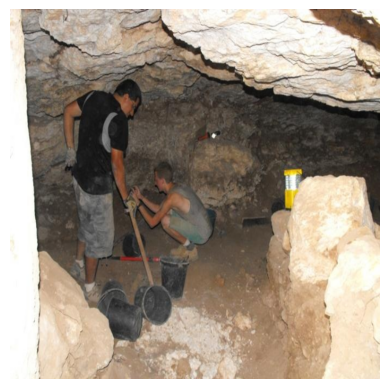

Output shape: (1, 3, 640, 640)


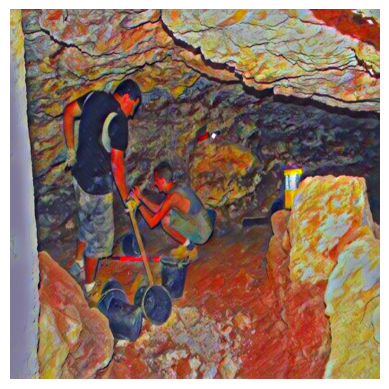

showing ../data/objects365_val_patch1/objects365_v1_00045989.jpg


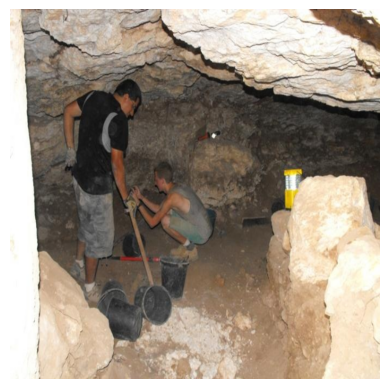

Output shape: (1, 3, 640, 640)


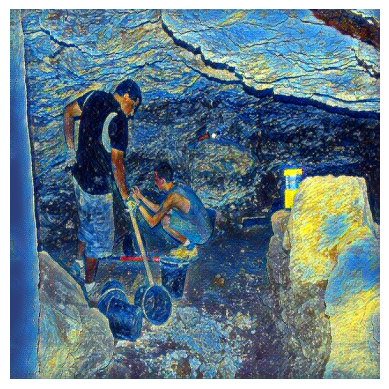

In [5]:
# pass example image through the network
# load image from data folder
from transformer_net_fusion import TransformerNetFusion


def stylize_and_display_image(image_path: Path, model_path: Path, dtype=np.float32):
    print("showing",image_path)
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 640))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    input_tensor = image.astype(dtype)
    input_tensor = np.transpose(input_tensor, (2,0,1)) # HWC to CHW
    input_tensor = np.expand_dims(input_tensor, axis=0) # add batch dim
    input_name = "input"
    ort_sess = ort.InferenceSession(model_path, providers=PROVIDERS)
    outputs = ort_sess.run(None, {input_name: input_tensor})
    output_tensor = outputs[0]
    print("Output shape:", output_tensor.shape)
    # display output as image
    output_image = np.squeeze(output_tensor, axis=0) # remove batch dim
    output_image = np.transpose(output_image, (1,2,0)) # CHW to
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

def stylize_and_display_image_pth(image_path: Path, pth_path: Path):
    print("showing",image_path)
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 640))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    input_tensor = image.astype(np.float32)
    input_tensor = np.transpose(input_tensor, (2,0,1)) # HWC to CHW
    input_tensor = np.expand_dims(input_tensor, axis=0) # add batch dim
    input_name = "input"
    
    model = TransformerNetFusion().to('cuda')
    model.load_state_dict(torch.load(pth_path))
    model.eval()
    with torch.no_grad():
        input_tensor_torch = torch.from_numpy(input_tensor).to('cuda')
        output_tensor_torch = model(input_tensor_torch)
        output_tensor = output_tensor_torch.cpu().numpy()
    print("Output shape:", output_tensor.shape)
    # display output as image
    output_image = np.squeeze(output_tensor, axis=0) # remove batch dim
    output_image = np.transpose(output_image, (1,2,0)) # CHW to
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

stylize_and_display_image(IMAGES_PATH / "objects365_v1_00045989.jpg", BASELINE_PATH)
stylize_and_display_image_pth(IMAGES_PATH / "objects365_v1_00045989.jpg", torch_model_path) # they look different??...

In [6]:
# create identity model for benchmark
import torch.nn as nn

class IdentityNet(nn.Module):
	def __init__(self):
		super().__init__()

		self.conv = nn.Conv2d(3,3,1)
		# initialize convolution as identity
		with torch.no_grad():
			self.conv.weight.zero_()
			for i in range(3):
				self.conv.weight[i, i, 0, 0] = 1.0
			self.conv.bias.zero_()
	
	def forward(self, x):
		x = self.conv(x)
		return x

# Example usage:
model = IdentityNet()
sample_input = torch.randn(input_shape)
output = model(sample_input)
print(output.shape)

# save to onnx
torch.onnx.export(
	model, 
	(torch.zeros(input_shape),), 
	IDENTITYNET_PATH, 
	input_names=["input"], 
	output_names=["output"], 
)

torch.Size([1, 3, 640, 640])


In [7]:
# optymalizacja
import onnxoptimizer
print(onnxoptimizer.get_fuse_and_elimination_passes())

passes = onnxoptimizer.get_fuse_and_elimination_passes()
optimized_model = onnxoptimizer.optimize(onnx_model, passes)
onnx.save(optimized_model, OPTIMISED_PATH)

['nop', 'eliminate_nop_cast', 'eliminate_nop_dropout', 'eliminate_nop_flatten', 'extract_constant_to_initializer', 'eliminate_consecutive_idempotent_ops', 'eliminate_if_with_const_cond', 'eliminate_nop_monotone_argmax', 'eliminate_nop_pad', 'eliminate_nop_concat', 'eliminate_nop_split', 'eliminate_nop_expand', 'eliminate_shape_gather', 'eliminate_slice_after_shape', 'eliminate_nop_transpose', 'fuse_add_bias_into_conv', 'fuse_bn_into_conv', 'fuse_consecutive_concats', 'fuse_consecutive_log_softmax', 'fuse_consecutive_reduce_unsqueeze', 'fuse_consecutive_squeezes', 'fuse_consecutive_transposes', 'fuse_matmul_add_bias_into_gemm', 'fuse_pad_into_conv', 'fuse_pad_into_pool', 'fuse_transpose_into_gemm', 'fuse_concat_into_reshape', 'eliminate_nop_reshape', 'eliminate_nop_with_unit', 'eliminate_common_subexpression', 'fuse_qkv', 'fuse_consecutive_unsqueezes', 'eliminate_deadend', 'eliminate_identity', 'eliminate_shape_op', 'fuse_consecutive_slices', 'eliminate_unused_initializer', 'eliminate_d

## Kwantyzacja

In [8]:
from onnxruntime.quantization import quantize_static, QuantType, CalibrationDataReader

In [9]:
# preprocess target model

from onnxruntime.quantization import preprocess

preprocess.quant_pre_process(converted, output_model_path="preprocessed.onnx")

In [10]:
# from https://medium.com/@nashrakhan1008/model-quantization-8f10c537e0eb

from concurrent.futures import ThreadPoolExecutor
import os
import cv2


class MyCalibrationDataReader(CalibrationDataReader):
    def __init__(self, image_folder, batch_size=1, input_size=(640, 640)):
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.input_size = input_size
        self.image_files = os.listdir(str(image_folder))
        self.index = 0

    def preprocess_image(self, img_path):
        """Preprocess image by reading and resizing."""
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.input_size)  # resize to input_size
        img = img.astype(np.float32)  # Ensure float32 for ONNX
        return img

    def get_next(self) -> dict:
        """Generate the next batch of input data for inference."""
        if self.index >= len(self.image_files):
            return None  # End of data

        # Create list of image paths for batch processing
        # Create list of image paths for batch processing
        batch_paths = [str(self.image_folder / self.image_files[i]) for i in range(self.index, self.index + self.batch_size)]
        
        # Parallelize image preprocessing
        with ThreadPoolExecutor() as executor:
            batch_images = list(executor.map(self.preprocess_image, batch_paths))
        # Stack and transpose images to match model input shape (batch_size, channels, height, width)
        batch_images = np.stack(batch_images, axis=0)
        batch_images = np.transpose(batch_images, (0, 3, 1, 2))

        # Increment index for next batch
        self.index += self.batch_size
        return {"input": batch_images}

    def __len__(self):
        """Calculate the total number of batches."""
        return len(self.image_files) // self.batch_size

In [11]:
# kwantyzacja
calibration = MyCalibrationDataReader(IMAGES_PATH, 1)

# Takes about 1 minut, uncomment to run
#quantize_static("preprocessed.onnx", 
#                "quantized_int8.onnx",
#                calibration,
#                )

## Inne podejście - konwersja na fp16

In [12]:
from onnxconverter_common import float16

fp16 = float16.convert_float_to_float16(onnx_model)

onnx.save(fp16, FP16_PATH)

measure_model(FP16_PATH,np.float16)

100%|██████████| 100/100 [00:02<00:00, 42.35it/s]


2.3658883571624756

## Destylacja modelu

Domyślnie model ma architekture autokodera z trzema warstwami splotowymi zmniejszającymi obraz, sześcioma do rozszerzenia pojemności modelu, oraz trzema powracającymi do oryginalnego rozmiaru.

Możliwe podejścia:
1. Zmniejszyć liczbę bloków w bottlenecku - modele `4res`, `3res`
2. Zmniejszyć długość kanałów - modele 
2. Zamienić splot na depth-wise separable convolution - ograniczenie liczby parametrów
    * Zamiast splotu po całych aktywacjach, robi się splot na pojedyńczych kanałach, a potem point-wisee splot z jądrem 1x1 aby otrzymać wynik


In [13]:
from transformerNetFusion_res1 import TransformerNetFusion_res1
from transformerNetFusion_res2 import TransformerNetFusion_res2
from transformerNetFusion_separated import TransformerNetFusion_separated
from transformerNetFusion_separated_scaled import TransformerNetFusion_separated_scaled


for model, name, path in [
    (TransformerNetFusion_res1(), "4res", RES1_PATH),
    (TransformerNetFusion_res2(), "3res", RES2_PATH),
    (TransformerNetFusion_separated(), "separated", SEPARATED_PATH),
    (TransformerNetFusion_separated_scaled(alpha=0.75), "separated_scaled", SEPARATED_2xSCALED_PATH),
    (TransformerNetFusion_separated_scaled(alpha=0.5), "separated_scaled", SEPARATED_4xSCALED_PATH),
]:
    sample_input = torch.randn(input_shape)
    torch.onnx.export(
        model, 
        (sample_input,), 
        path, 
        input_names=["input"], 
        output_names=["output"],
        opset_version=9,
        do_constant_folding=True
    )

# run onnxoptimiser on distilled models, because pytorch exports some trash
for path in [RES1_PATH, RES2_PATH, SEPARATED_PATH]:
    onnx_model = onnx.load(path)
    optimized_model = onnxoptimizer.optimize(onnx_model)
    onnx.save(optimized_model, path)

# export as fp16
for path in [RES1_PATH, RES2_PATH, SEPARATED_PATH, SEPARATED_2xSCALED_PATH, SEPARATED_4xSCALED_PATH]:
    onnx_model = onnx.load(path)
    fp16 = float16.convert_float_to_float16(onnx_model)
    onnx.save(fp16, path.with_stem(path.stem + "_fp16"))


/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:1460: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(
/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:798: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(
/home/tomek/.venv/lib/python3.12/site-packages/onnxconverter_common/float16.py:52: UserWarning: the float32 number 3.161013495400766e-08 will be truncated to 1e

## Porównanie modeli

In [14]:
special_models = [IDENTITYNET_PATH, OPTIMISED_PATH, QUANTIZED_PATH] # models without fp16 versions
models = (BASELINE_PATH, RES2_PATH, RES1_PATH, SEPARATED_PATH, SEPARATED_2xSCALED_PATH, SEPARATED_4xSCALED_PATH)

times = {}

for path in special_models:
    elapsed = measure_model(path, np.float32)
    print(f"{path.name}, Elapsed {elapsed:.3f}s")
    times[path.name] = elapsed

for path in models:
    elapsed = measure_model(path, np.float32)
    print(f"{path.name}, Elapsed {elapsed:.3f}s")
    times[path.name] = elapsed

for path in models:
    fp16_path = path.with_stem(path.stem + "_fp16")
    elapsed = measure_model(fp16_path, np.float16)
    print(f"{fp16_path.name}, Elapsed {elapsed:.3f}s")
    times[fp16_path.name] = elapsed

100%|██████████| 100/100 [00:00<00:00, 118.47it/s]


identity.onnx, Elapsed 0.847s


100%|██████████| 100/100 [00:03<00:00, 29.74it/s]
2026-01-12 03:29:51.852532758 [W:onnxruntime:, transformer_memcpy.cc:111 ApplyImpl] 23 Memcpy nodes are added to the graph torch-jit-export for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2026-01-12 03:29:51.853483348 [W:onnxruntime:, session_state.cc:1316 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2026-01-12 03:29:51.853490276 [W:onnxruntime:, session_state.cc:1318 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


optimised.onnx, Elapsed 3.365s


100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


quantized_int8.onnx, Elapsed 4.064s


100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


baseline.onnx, Elapsed 3.348s


100%|██████████| 100/100 [00:03<00:00, 32.23it/s]


transformerNetFusion_res2.onnx, Elapsed 3.105s


100%|██████████| 100/100 [00:02<00:00, 34.10it/s]


transformerNetFusion_res1.onnx, Elapsed 2.934s


100%|██████████| 100/100 [00:02<00:00, 44.25it/s]


transformerNetFusion_separated.onnx, Elapsed 2.263s


100%|██████████| 100/100 [00:01<00:00, 54.16it/s]


transformerNetFusion_separated_2xscaled.onnx, Elapsed 1.848s


100%|██████████| 100/100 [00:01<00:00, 73.24it/s]


transformerNetFusion_separated_4xscaled.onnx, Elapsed 1.367s


100%|██████████| 100/100 [00:02<00:00, 46.32it/s]


baseline_fp16.onnx, Elapsed 2.160s


100%|██████████| 100/100 [00:02<00:00, 47.60it/s]


transformerNetFusion_res2_fp16.onnx, Elapsed 2.102s


100%|██████████| 100/100 [00:01<00:00, 50.26it/s]


transformerNetFusion_res1_fp16.onnx, Elapsed 1.991s


100%|██████████| 100/100 [00:02<00:00, 48.11it/s]


transformerNetFusion_separated_fp16.onnx, Elapsed 2.081s


100%|██████████| 100/100 [00:01<00:00, 57.32it/s]


transformerNetFusion_separated_2xscaled_fp16.onnx, Elapsed 1.746s


100%|██████████| 100/100 [00:01<00:00, 75.67it/s]

transformerNetFusion_separated_4xscaled_fp16.onnx, Elapsed 1.325s


In [24]:
sorted_times = dict(sorted(times.items(), key=lambda item: item[1]))
sorted_times

NameError: name 'times' is not defined

# Trening
Skoro już mamy modele i wiemy ile czasu chodzą, to je trenujemy

In [14]:
# loader with random real images to train on something
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader

def get_torchvision_loader(batch_size=4, subset=range(1000)):
    transform = transforms.Compose([
        # only resize if the smallest side is less than 640
        transforms.Lambda(lambda img: F.resize(img, 640) if min(img.size) < 640 else img),
        
        transforms.CenterCrop(640),
        transforms.ToTensor(),
    ])
    
    dataset = datasets.ImageFolder(
        root='../data', 
        transform=transform
    )
    subset = torch.utils.data.Subset(dataset, list(subset))

    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    return loader

In [20]:
import torch.optim as optim
from transformer_net_fusion import TransformerNetFusion # teacher
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_distillation(teacher_model_path, student_output_path, student_model, train_loader, val_loader,num_epochs=10):
    torch.cuda.empty_cache()
    student_model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # load teacher model from pth
    teacher_model = TransformerNetFusion().to(device)
    teacher_model.load_state_dict(torch.load(teacher_model_path))
    teacher_model.eval()
    student_model.to(device)
    
    optimizer = optim.Adam(student_model.parameters(), lr=1e-2)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    distillation_loss_fn = nn.MSELoss()

    #dummy_input = torch.randn(1, 3, 640, 640).to(device)
    print("train start")

    scaler = torch.amp.GradScaler('cuda')

    train_loss = 0.0
    total_elements = 0
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            batch = batch[0].to(device)  # get images from (images, labels) tuple
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                with torch.no_grad():
                    teacher_output = teacher_model(batch)

                student_output = student_model(batch)

                loss = distillation_loss_fn(student_output, teacher_output)
                train_loss += loss.item() * batch.size(0)
                total_elements += batch.size(0)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # validate epoch
        student_model.eval()
        val_loss = 0.0
        total_val_elements = 0
        with torch.no_grad():
            for val_batch in tqdm(val_loader,desc="Validation"):
                val_batch = val_batch[0].to(device)
                teacher_output = teacher_model(val_batch)
                student_output = student_model(val_batch)
                loss = distillation_loss_fn(student_output, teacher_output)
                val_loss += loss.item() * val_batch.size(0)
                total_val_elements += val_batch.size(0)

        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/total_elements:.6f}, Val Loss: {val_loss/total_val_elements:.6f}")
        # export trained student model every epoch, because why not
        print("exporting to",student_output_path)
        torch.cuda.empty_cache()
        sample_input = torch.randn(input_shape).to(device)
        torch.onnx.export(
            student_model, 
            (sample_input,), 
            student_output_path.with_stem(student_output_path.stem + "_distilled"), 
            input_names=["input"], 
            output_names=["output"],
            opset_version=9,
            do_constant_folding=True
        )
        # export pth too
        torch.save(student_model.state_dict(), student_output_path.with_suffix(".pth"))

In [ ]:
# this is slower and limited only to output comparison, but possible
def train_distillation_onnx(student_model, train_loader, val_loader, num_epochs=15):
    # 1. Load the ONNX Teacher
    # Use 'CUDAExecutionProvider' if you have onnxruntime-gpu installed
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
    teacher_session = ort.InferenceSession(BASELINE_PATH, providers=providers)
    
    # Get input names for the ONNX model
    input_name_x = teacher_session.get_inputs()[0].name

    # 2. Initialize PyTorch Student
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student_model = TransformerNetFusion_separated().to(device)
    student_model.train()

    optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
    distillation_loss_fn = nn.MSELoss()

    # Dummy Data

    # 3. Training Loop
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            img = batch[0]  # get images from (images, labels) tuple
            optimizer.zero_grad()

            # --- Teacher Inference (ONNX) ---
            # ONNX requires numpy arrays, not torch tensors
            x_numpy = img.cpu().numpy()
            
            # Run inference
            onnx_outputs = teacher_session.run(None, {
                input_name_x: x_numpy,
            })
            
            # Convert teacher output back to torch and move to device
            teacher_output = torch.from_numpy(onnx_outputs[0]).to(device)

            # --- Student Inference (PyTorch) ---
            student_output = student_model(img.to(device))

            # 4. Loss and Backprop
            loss = distillation_loss_fn(student_output, teacher_output)
            loss.backward()
            optimizer.step()
        
        # validate
        student_model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                img = batch[0]
                student_output = student_model(img.to(device))
                # Compute validation loss if needed
                # ...
                x_numpy = img.cpu().numpy()
            
                # Run inference
                onnx_outputs = teacher_session.run(None, {
                    input_name_x: x_numpy,
                })
                
                # Convert teacher output back to torch and move to device
                teacher_output = torch.from_numpy(onnx_outputs[0]).to(device)
                val_loss = distillation_loss_fn(student_output, teacher_output)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

In [ ]:
from transformerNetFusion_separated_scaled import TransformerNetFusion_separated_scaled

torch.cuda.empty_cache()
train_loader = get_torchvision_loader(batch_size=4, subset=range(1100))
val_loader = get_torchvision_loader(batch_size=4, subset=range(1100,1200))

train_distillation(torch_model_path, SEPARATED_PATH, TransformerNetFusion_separated_scaled(), train_loader, val_loader, num_epochs=20)
train_distillation(torch_model_path, SEPARATED_2xSCALED_PATH, TransformerNetFusion_separated_scaled(alpha=0.75), train_loader, val_loader, num_epochs=20)
train_distillation(torch_model_path, SEPARATED_4xSCALED_PATH, TransformerNetFusion_separated_scaled(alpha=0.5), train_loader, val_loader, num_epochs=20)
train_distillation(torch_model_path, RES1_PATH, TransformerNetFusion_res1(), train_loader, val_loader, num_epochs=20)
train_distillation(torch_model_path, RES2_PATH, TransformerNetFusion_res2(), train_loader, val_loader, num_epochs=20)


train start


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.43it/s]
/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:1460: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(
/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:798: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(


Epoch [1/20], Loss: 3785.782162, Val Loss: 2328.188174
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


Epoch [2/20], Loss: 2871.929880, Val Loss: 1509.559971
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.37it/s]


Epoch [3/20], Loss: 2339.596388, Val Loss: 1183.783979
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


Epoch [4/20], Loss: 2008.272471, Val Loss: 965.128376
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]


Epoch [5/20], Loss: 1780.637169, Val Loss: 831.849309
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s]


Epoch [6/20], Loss: 1614.637036, Val Loss: 757.468108
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch [7/20], Loss: 1486.244190, Val Loss: 761.604937
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.43it/s]


Epoch [8/20], Loss: 1385.130618, Val Loss: 667.139155
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


Epoch [9/20], Loss: 1302.490554, Val Loss: 674.952415
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.37it/s]


Epoch [10/20], Loss: 1234.748378, Val Loss: 634.909604
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]


Epoch [11/20], Loss: 1176.316970, Val Loss: 572.080068
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch [12/20], Loss: 1126.304209, Val Loss: 563.343510
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch [13/20], Loss: 1082.917349, Val Loss: 555.016948
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Epoch [14/20], Loss: 1044.507535, Val Loss: 545.341888
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


Epoch [15/20], Loss: 1010.179639, Val Loss: 546.298315
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.97it/s]


Epoch [16/20], Loss: 980.453126, Val Loss: 539.838503
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


Epoch [17/20], Loss: 952.868036, Val Loss: 500.438522
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch [18/20], Loss: 927.529760, Val Loss: 494.792253
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.43it/s]


Epoch [19/20], Loss: 905.035489, Val Loss: 500.848057
exporting to transformerNetFusion_separated.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


Epoch [20/20], Loss: 884.494470, Val Loss: 562.017166
exporting to transformerNetFusion_separated.onnx
train start


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s]


Epoch [1/20], Loss: 3849.346030, Val Loss: 2302.171455
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]


Epoch [2/20], Loss: 2916.859106, Val Loss: 1604.685220
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s]


Epoch [3/20], Loss: 2393.563588, Val Loss: 1215.539746
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s]


Epoch [4/20], Loss: 2070.246375, Val Loss: 1023.711836
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


Epoch [5/20], Loss: 1849.174626, Val Loss: 933.608242
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s]


Epoch [6/20], Loss: 1689.268178, Val Loss: 851.223557
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch [7/20], Loss: 1565.342858, Val Loss: 812.930315
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]


Epoch [8/20], Loss: 1467.104704, Val Loss: 753.216909
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s]


Epoch [9/20], Loss: 1385.968324, Val Loss: 729.401204
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s]


Epoch [10/20], Loss: 1318.427442, Val Loss: 687.512200
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.02it/s]


Epoch [11/20], Loss: 1259.926337, Val Loss: 702.495718
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  5.00it/s]


Epoch [12/20], Loss: 1211.115407, Val Loss: 696.069814
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.97it/s]


Epoch [13/20], Loss: 1168.073970, Val Loss: 638.966223
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch [14/20], Loss: 1129.184656, Val Loss: 625.775435
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s]


Epoch [15/20], Loss: 1095.412036, Val Loss: 637.620752
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch [16/20], Loss: 1064.952545, Val Loss: 602.611116
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch [17/20], Loss: 1037.704018, Val Loss: 609.666453
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch [18/20], Loss: 1013.101175, Val Loss: 607.585872
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch [19/20], Loss: 990.566425, Val Loss: 579.185620
exporting to transformerNetFusion_separated_2xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch [20/20], Loss: 969.318928, Val Loss: 577.671033
exporting to transformerNetFusion_separated_2xscaled.onnx
train start


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Epoch [1/20], Loss: 4063.373267, Val Loss: 2348.733057
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.66it/s]


Epoch [2/20], Loss: 3086.347063, Val Loss: 1812.933662
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.71it/s]


Epoch [3/20], Loss: 2570.444233, Val Loss: 1384.184810
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.78it/s]


Epoch [4/20], Loss: 2241.734312, Val Loss: 1190.749346
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.77it/s]


Epoch [5/20], Loss: 2021.810500, Val Loss: 1125.136836
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Epoch [6/20], Loss: 1861.713109, Val Loss: 1036.903020
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch [7/20], Loss: 1736.979699, Val Loss: 1024.763220
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.62it/s]


Epoch [8/20], Loss: 1636.871245, Val Loss: 923.576770
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.49it/s]


Epoch [9/20], Loss: 1555.109709, Val Loss: 896.855178
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


Epoch [10/20], Loss: 1485.972947, Val Loss: 861.959375
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch [11/20], Loss: 1427.731375, Val Loss: 834.639033
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch [12/20], Loss: 1376.986550, Val Loss: 823.038389
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch [13/20], Loss: 1333.019697, Val Loss: 795.367136
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]


Epoch [14/20], Loss: 1294.419930, Val Loss: 788.178672
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.22it/s]


Epoch [15/20], Loss: 1259.184209, Val Loss: 777.811450
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


Epoch [16/20], Loss: 1227.874067, Val Loss: 765.352197
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


Epoch [17/20], Loss: 1199.507962, Val Loss: 748.405251
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


Epoch [18/20], Loss: 1173.810168, Val Loss: 745.494937
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


Epoch [19/20], Loss: 1150.466305, Val Loss: 722.036101
exporting to transformerNetFusion_separated_4xscaled.onnx


Validation: 100%|██████████| 25/25 [00:04<00:00,  5.44it/s]


Epoch [20/20], Loss: 1128.925460, Val Loss: 732.799751
exporting to transformerNetFusion_separated_4xscaled.onnx
train start


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


Epoch [1/20], Loss: 3463.979764, Val Loss: 2588.929805
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]


Epoch [2/20], Loss: 2898.232542, Val Loss: 2158.146553
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.42it/s]


Epoch [3/20], Loss: 2599.217872, Val Loss: 1770.189116
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.37it/s]


Epoch [4/20], Loss: 2331.068550, Val Loss: 1348.445273
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]


Epoch [5/20], Loss: 2108.500574, Val Loss: 1132.816060
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.31it/s]


Epoch [6/20], Loss: 1931.103651, Val Loss: 1007.858728
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


Epoch [7/20], Loss: 1782.442743, Val Loss: 849.597732
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s]


Epoch [8/20], Loss: 1658.336422, Val Loss: 779.812185
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]


Epoch [9/20], Loss: 1554.822922, Val Loss: 716.336038
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.40it/s]


Epoch [10/20], Loss: 1466.593633, Val Loss: 668.474324
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.37it/s]


Epoch [11/20], Loss: 1391.694443, Val Loss: 643.683430
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.31it/s]


Epoch [12/20], Loss: 1325.878025, Val Loss: 608.459102
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


Epoch [13/20], Loss: 1268.976551, Val Loss: 591.690505
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.35it/s]


Epoch [14/20], Loss: 1218.810014, Val Loss: 621.896470
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.36it/s]


Epoch [15/20], Loss: 1174.592229, Val Loss: 549.114575
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch [16/20], Loss: 1134.626406, Val Loss: 548.254209
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s]


Epoch [17/20], Loss: 1098.128432, Val Loss: 539.841383
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch [18/20], Loss: 1066.153019, Val Loss: 504.069725
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.28it/s]


Epoch [19/20], Loss: 1036.231415, Val Loss: 491.982445
exporting to transformerNetFusion_res1.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.27it/s]


Epoch [20/20], Loss: 1009.094192, Val Loss: 498.330134
exporting to transformerNetFusion_res1.onnx
train start


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch [1/20], Loss: 3451.804458, Val Loss: 2565.907695
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.17it/s]


Epoch [2/20], Loss: 2891.933684, Val Loss: 2178.286270
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch [3/20], Loss: 2547.333546, Val Loss: 1616.801914
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


Epoch [4/20], Loss: 2254.679711, Val Loss: 1221.126680
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch [5/20], Loss: 2024.919074, Val Loss: 1051.135386
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


Epoch [6/20], Loss: 1841.869468, Val Loss: 864.131743
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.40it/s]


Epoch [7/20], Loss: 1691.377068, Val Loss: 752.084912
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]


Epoch [8/20], Loss: 1567.068565, Val Loss: 678.836128
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


Epoch [9/20], Loss: 1462.091925, Val Loss: 634.858135
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s]


Epoch [10/20], Loss: 1374.662929, Val Loss: 573.872034
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.28it/s]


Epoch [11/20], Loss: 1298.491533, Val Loss: 547.264498
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]


Epoch [12/20], Loss: 1232.744282, Val Loss: 505.087917
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch [13/20], Loss: 1175.582556, Val Loss: 498.660824
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


Epoch [14/20], Loss: 1125.392425, Val Loss: 474.240026
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]


Epoch [15/20], Loss: 1080.097296, Val Loss: 461.078274
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch [16/20], Loss: 1040.490308, Val Loss: 463.941902
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


Epoch [17/20], Loss: 1005.332543, Val Loss: 431.412545
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.25it/s]


Epoch [18/20], Loss: 972.356127, Val Loss: 406.777341
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.32it/s]


Epoch [19/20], Loss: 942.378964, Val Loss: 449.681674
exporting to transformerNetFusion_res2.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.36it/s]

Epoch [20/20], Loss: 915.225804, Val Loss: 400.548303
exporting to transformerNetFusion_res2.onnx


In [ ]:
# also distil the original model to see how low the metrics can go
train_distillation(torch_model_path, Path("baseline_distilled.onnx"), TransformerNetFusion(), train_loader, val_loader, num_epochs=20)

train start


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]
/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:1460: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(
/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:798: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(


Epoch [1/20], Loss: 3557.204893, Val Loss: 2564.836563
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]


Epoch [2/20], Loss: 2954.636836, Val Loss: 2206.283691
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


Epoch [3/20], Loss: 2643.277666, Val Loss: 1769.799097
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch [4/20], Loss: 2362.544008, Val Loss: 1334.406406
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


Epoch [5/20], Loss: 2125.155591, Val Loss: 1060.846445
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]


Epoch [6/20], Loss: 1928.882938, Val Loss: 867.996343
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Epoch [7/20], Loss: 1764.737999, Val Loss: 735.167383
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


Epoch [8/20], Loss: 1631.162291, Val Loss: 670.478259
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Epoch [9/20], Loss: 1516.064421, Val Loss: 556.572614
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]


Epoch [10/20], Loss: 1418.626096, Val Loss: 549.010662
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Epoch [11/20], Loss: 1336.638908, Val Loss: 575.621055
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Epoch [12/20], Loss: 1265.759963, Val Loss: 495.359020
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Epoch [13/20], Loss: 1203.108366, Val Loss: 465.337397
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Epoch [14/20], Loss: 1147.470785, Val Loss: 429.659589
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Epoch [15/20], Loss: 1098.876608, Val Loss: 412.101157
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]


Epoch [16/20], Loss: 1055.144029, Val Loss: 404.450881
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.97it/s]


Epoch [17/20], Loss: 1016.042187, Val Loss: 443.811101
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch [18/20], Loss: 980.310000, Val Loss: 369.154547
exporting to baseline_distilled.onnx


Validation: 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


Epoch [19/20], Loss: 947.536210, Val Loss: 355.844091
exporting to baseline_distilled.onnx


 55%|█████▍    | 151/275 [00:46<00:38,  3.22it/s]

In [63]:
# after training, make fp16 verisons
# this could be done during training too for potentially slightly better results
for path in [RES1_PATH, RES2_PATH, SEPARATED_PATH, SEPARATED_2xSCALED_PATH, SEPARATED_4xSCALED_PATH]:
    onnx_model = onnx.load(path.with_stem(path.stem + "_distilled"))
    fp16 = float16.convert_float_to_float16(onnx_model)
    onnx.save(fp16, path.with_stem(path.stem + "_distilled_fp16"))

showing ../data/objects365_val_patch1/objects365_v1_00083540.jpg


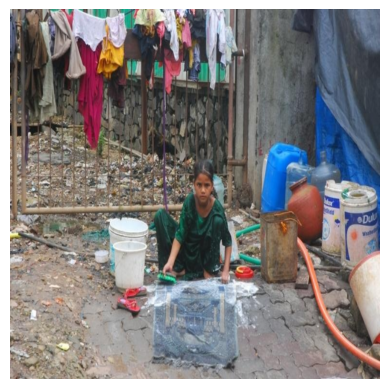

Output shape: (1, 3, 640, 640)


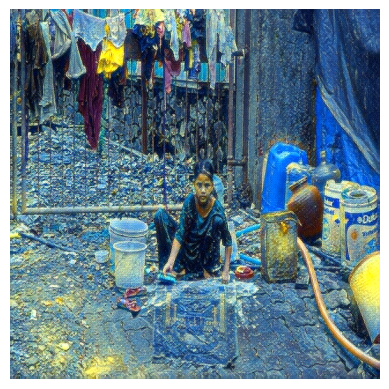

In [27]:
# check what the distilation model does
torch.cuda.empty_cache()
stylize_and_display_image(IMAGES_PATH / "objects365_v1_00083540.jpg", "/home/tomek/github/GBGST-optimisations/optimisation/transformerNetFusion_separated_4xscaled_distilled.onnx", dtype=np.float32)